### Predict the next best action for each customer based on their profile and previous touchpoints

### Aim: Based on a customer's profile, predict which type of touchpoint is most likely to result in a purchase

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('./marketdata.xlsx', sheet_name=0)

In [3]:
df.head()

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints
0,38,single,P4,,51000.0,C,5007.50,emailDestination mailDiscount,2
1,39,divorced,P3,,100000.0,B,19.74,emailDestination mailGift,2
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3
3,57,single,P2,Y,80600.0,C,164.21,NaN,0
4,60,married,P4,,152000.0,C,39.47,mailDiscount,1


### Checking for missing values

In [4]:
df.drop_duplicates()

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints
0,38,single,P4,,51000.0,C,5007.50,emailDestination mailDiscount,2
1,39,divorced,P3,,100000.0,B,19.74,emailDestination mailGift,2
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3
3,57,single,P2,Y,80600.0,C,164.21,NaN,0
4,60,married,P4,,152000.0,C,39.47,mailDiscount,1
...,...,...,...,...,...,...,...,...,...
19995,38,married,P3,Y,36000.0,C,285.06,NaN,0
19996,44,married,P4,,30000.0,NaN,1607.50,NaN,0
19997,30,single,P4,N,44000.0,C,4010.00,emailDestination emailDestination mailDiscount...,4
19998,52,married,P4,N,71000.0,C,507.46,emailDestination mailGift emailDiscount smsDes...,8


In [5]:
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

nan_check(df)

,Total,%
touchpoints,5000,25.0
creditRating,583,2.9
nTouchpoints,0,0.0
aveSpend,0,0.0
income,0,0.0
SocialMedia,0,0.0
segment,0,0.0
marital,0,0.0
age,0,0.0


We see that 25% of entries do not have touchpoints and 2.9% of entries do not have credit rating. Missing touchpoints could mean that the customers purchased without having to go through any online promotion links etc. The lack of credit rating might point to new customers who just joined Maybank.

I also noted that missing values under SocialMedia column were denoted with empty spaces.

Treating missing values for each column:
1. SocialMedia - change ' ' to 'U' (denotes Unknown social media status)
2. creditRating - change NaN to 'New' (denotes new customers)
3. touchpoints - I consider removing all rows with NaN touchpoints value since my aim would be to predict a customer's next touchpoint

In [6]:
data = df[df['nTouchpoints']!=0].reset_index().drop('index', axis=1)
data

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints
0,38,single,P4,,51000.0,C,5007.50,emailDestination mailDiscount,2
1,39,divorced,P3,,100000.0,B,19.74,emailDestination mailGift,2
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3
3,60,married,P4,,152000.0,C,39.47,mailDiscount,1
4,47,married,P2,Y,60000.0,A,19.89,mailDestination emailDestination emailDestination,3
...,...,...,...,...,...,...,...,...,...
14995,32,married,P1,,33000.0,E,4280.63,emailDestination emailDestination emailDestina...,7
14996,53,divorced,P3,N,61000.0,F,1332.29,smsDestination mailDiscount emailDestination e...,6
14997,30,single,P4,N,44000.0,C,4010.00,emailDestination emailDestination mailDiscount...,4
14998,52,married,P4,N,71000.0,C,507.46,emailDestination mailGift emailDiscount smsDes...,8


#### Cleaning touchpoints column

Assumption: I assume that the touchpoints are stated in order from left to right, so the last value is the most recent touchpoint for a customer before making a purchase. I will hence take only the last value as labels to predict which touchpoint should be assigned for a future customer

In [7]:
data['recent_touchpoint'] = data['touchpoints'].apply(lambda x: x.split()[-1])
data.recent_touchpoint.value_counts()

emailDestination    5542
emailDiscount       3240
mailDiscount        1837
smsDiscount         1149
emailGift            722
mailDestination      684
mailGift             643
smsGift              598
smsDestination       585
Name: recent_touchpoint, dtype: int64

We are now left with 15000 entries after removing rows without touchpoints value. I will now clean the SocialMedia and creditRating columns by replacing their respective values as stated above.

In [8]:
data.loc[data['SocialMedia'] == ' ', 'SocialMedia'] = 'U'
data = data.fillna(value={'creditRating': 'New'})
data.head()

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints,recent_touchpoint
0,38,single,P4,U,51000.0,C,5007.50,emailDestination mailDiscount,2,mailDiscount
1,39,divorced,P3,U,100000.0,B,19.74,emailDestination mailGift,2,mailGift
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3,emailDiscount
3,60,married,P4,U,152000.0,C,39.47,mailDiscount,1,mailDiscount
4,47,married,P2,Y,60000.0,A,19.89,mailDestination emailDestination emailDestination,3,emailDestination


In [9]:
data.creditRating.value_counts()

C      3839
B      3783
A      3103
D      2013
E      1321
New     435
F       420
G        86
Name: creditRating, dtype: int64

I would like to convert creditRating into a numerical column for future use in my model. 

##### New - 0, A - 1, B - 2, C - 3, D - 4, E - 5, F - 6, G - 7

In [10]:
data['num_creditRating']=data['creditRating'].replace({'New':0,'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
data

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints,recent_touchpoint,num_creditRating
0,38,single,P4,U,51000.0,C,5007.50,emailDestination mailDiscount,2,mailDiscount,3
1,39,divorced,P3,U,100000.0,B,19.74,emailDestination mailGift,2,mailGift,2
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3,emailDiscount,4
3,60,married,P4,U,152000.0,C,39.47,mailDiscount,1,mailDiscount,3
4,47,married,P2,Y,60000.0,A,19.89,mailDestination emailDestination emailDestination,3,emailDestination,1
...,...,...,...,...,...,...,...,...,...,...,...
14995,32,married,P1,U,33000.0,E,4280.63,emailDestination emailDestination emailDestina...,7,mailDiscount,5
14996,53,divorced,P3,N,61000.0,F,1332.29,smsDestination mailDiscount emailDestination e...,6,mailDiscount,6
14997,30,single,P4,N,44000.0,C,4010.00,emailDestination emailDestination mailDiscount...,4,mailDiscount,3
14998,52,married,P4,N,71000.0,C,507.46,emailDestination mailGift emailDiscount smsDes...,8,emailDestination,3


I would like to explore the relationship of the segment variable with other variables in my dataset. Some possibilities could be segmentation based on income, average spending, credit rating or a combination. I will explore the relationships with pivot tables and graphs

In [11]:
pd.pivot_table(data, index=['segment'], values=['income'], aggfunc='mean')

,income
segment,
P1,71379.087693
P2,71646.301270
P3,71810.789388
P4,71499.633076


In [12]:
pd.pivot_table(data, index=['segment'], values=['aveSpend'], aggfunc='mean')

,aveSpend
segment,
P1,715.399740
P2,706.095486
P3,735.732669
P4,753.432867


Mean income and mean average spending in each segment does not show much variation. Explore further with credit rating

In [13]:
cred_income = pd.pivot_table(data, index=['segment','num_creditRating'], values=['income'], aggfunc='mean').sort_values(['segment',
                                                                                                       'income'], ascending=False)
cred_income

income
segment num_creditRating              
P4      6                 76610.116071
        1                 74793.599733
        3                 72713.074507
        2                 72078.734531
        4                 67678.366117
        5                 65995.468503
        0                 61869.591837
        7                 60750.000000
P3      6                 78152.957143
        1                 76140.611153
        2                 72684.158522
        4                 70762.586317
        3                 69852.570706
        5                 69028.468829
        0                 59803.980769
        7                 54348.000000
P2      6                 86526.443761
        1                 78185.272539
        3                 71800.064366
        2                 71224.038883
        4                 67426.992634
        5                 66171.549514
        0                 56995.299145
        7                 49956.521739
P1      1                 75633.995214
        6                 75116.208602
        3                 72396.773169
        2                 71798.957554
        4                 67014.696057
        5                 67000.301728
        0                 59930.913793
        7                 59618.290000

Customers with credit rating of 6,1,3 seem to have the highest average income while those with 5/0/7 are in the lower range. Customers with median earnings have credit ratings of 2/4.

In [14]:
avg_spend=pd.pivot_table(data, index=['segment','num_creditRating'], values=['aveSpend'], aggfunc='mean').sort_values(['segment',
                                                                                                       'aveSpend'], ascending=False)
avg_spend

aveSpend
segment num_creditRating             
P4      7                  955.989583
        5                  914.850510
        3                  858.210052
        0                  795.572755
        2                  760.531279
        1                  707.435722
        4                  589.540020
        6                  333.942321
P3      7                  973.084211
        3                  901.073444
        1                  734.510722
        6                  720.506633
        2                  692.694207
        4                  668.161029
        5                  598.784444
        0                  367.397981
P2      3                  940.232998
        7                  848.971739
        1                  726.388212
        5                  681.799027
        2                  659.542582
        0                  594.950598
        4                  464.909337
        6                  250.612821
P1      7                 1167.194500
        3                  870.604299
        0                  846.139052
        1                  740.226020
        5                  699.553333
        2                  607.028798
        4                  596.789528
        6                  457.905699

Customers with credit rating of 7 seem to have a higher range of average spendings across all segments, even though they belong in the lower end of income earnings

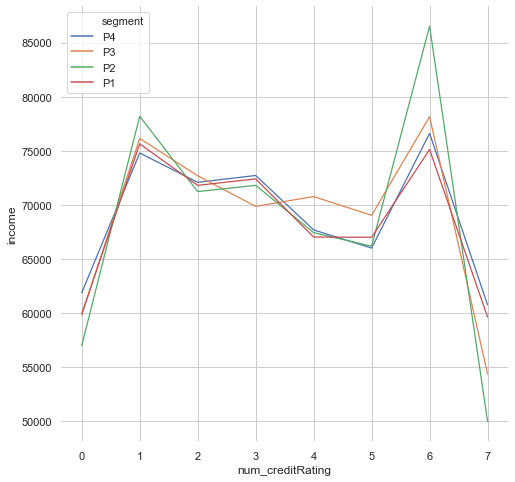

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(8,8))
sns.despine(f, left=True, bottom=True)
ax=sns.lineplot(data=cred_income.reset_index(),x='num_creditRating',y='income',hue='segment',
               sizes=(1, 8), linewidth=1.25)

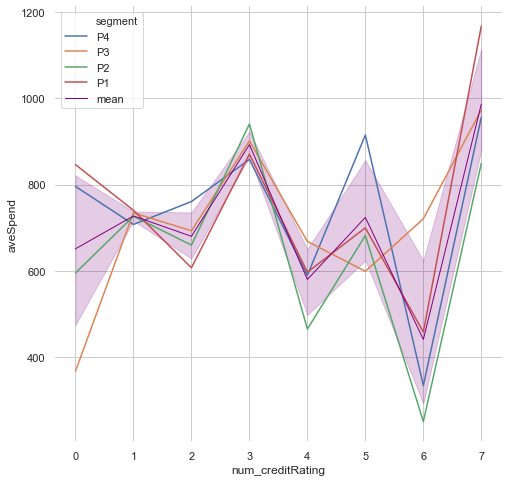

In [16]:
f, ax = plt.subplots(figsize=(8,8))
sns.despine(f, left=True, bottom=True)
ax=sns.lineplot(data=avg_spend.reset_index(),x='num_creditRating',y='aveSpend',hue='segment',
               sizes=(1, 8), linewidth=1.5)
ax2=sns.lineplot(data=avg_spend.reset_index(),x='num_creditRating',y='aveSpend',estimator='mean',
               sizes=(1, 8), linewidth=1,ci=95,color='purple',label='mean')

There isn't a general pattern we can observe with average spending over each credit ratings as seen from each line plot for P1 to P4. The purple line shows us mean average spending per credit rating group and its 95% confidence interval. Comparing both plots, it seems that the high earners with credit rating of 6 spends less than others, and low earners with credit rating of 7 spends more than others.

In [17]:
data

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints,recent_touchpoint,num_creditRating
0,38,single,P4,U,51000.0,C,5007.50,emailDestination mailDiscount,2,mailDiscount,3
1,39,divorced,P3,U,100000.0,B,19.74,emailDestination mailGift,2,mailGift,2
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3,emailDiscount,4
3,60,married,P4,U,152000.0,C,39.47,mailDiscount,1,mailDiscount,3
4,47,married,P2,Y,60000.0,A,19.89,mailDestination emailDestination emailDestination,3,emailDestination,1
...,...,...,...,...,...,...,...,...,...,...,...
14995,32,married,P1,U,33000.0,E,4280.63,emailDestination emailDestination emailDestina...,7,mailDiscount,5
14996,53,divorced,P3,N,61000.0,F,1332.29,smsDestination mailDiscount emailDestination e...,6,mailDiscount,6
14997,30,single,P4,N,44000.0,C,4010.00,emailDestination emailDestination mailDiscount...,4,mailDiscount,3
14998,52,married,P4,N,71000.0,C,507.46,emailDestination mailGift emailDiscount smsDes...,8,emailDestination,3


I want to check for any multicollinearity between the numerical variables. Multicollinearity reduces the precision of the estimate coefficients, which weakens the statistical power of our regression model. 

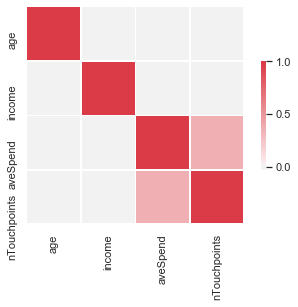

In [18]:
cmap = sns.diverging_palette(20,10, as_cmap=True)
sns.heatmap(data[['age','income','aveSpend','nTouchpoints']].corr(), vmax=1, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})

We see that number of touch points is highly correlated with average spending however the correlation is low-moderate below 0.5. Since the degree of multicollinearity is not severe, I will leave the variables untouched.

### Explore distributions for our variables

In [19]:
data.columns

Index(['age', 'marital', 'segment', 'SocialMedia', 'income', 'creditRating',
       'aveSpend', 'touchpoints', 'nTouchpoints', 'recent_touchpoint',
       'num_creditRating'],
      dtype='object')

Plot for MARITAL: total counts = 4


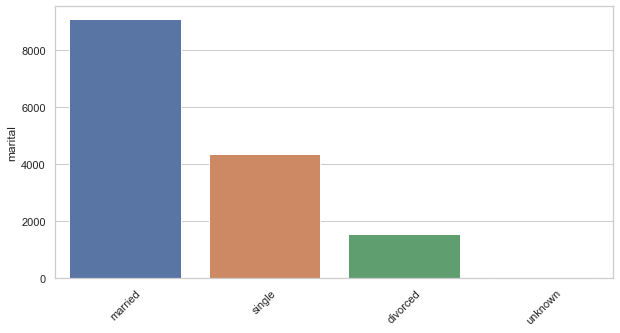

Plot for SEGMENT: total counts = 4


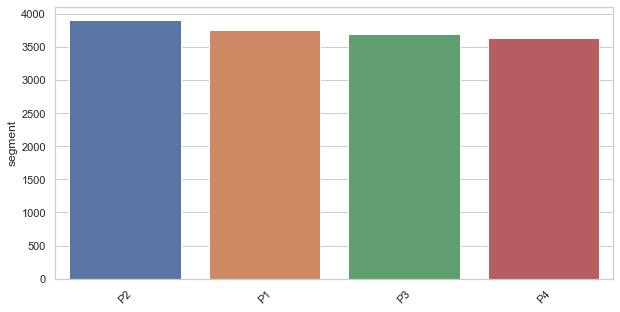

Plot for SOCIALMEDIA: total counts = 3


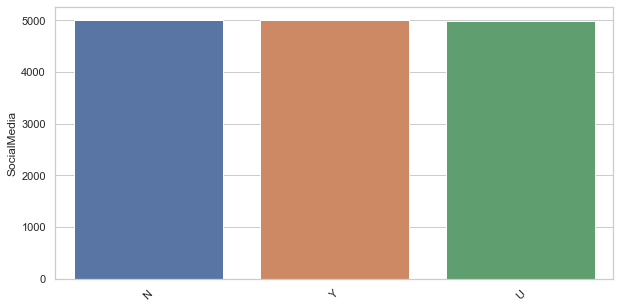

Plot for NUM_CREDITRATING: total counts = 8


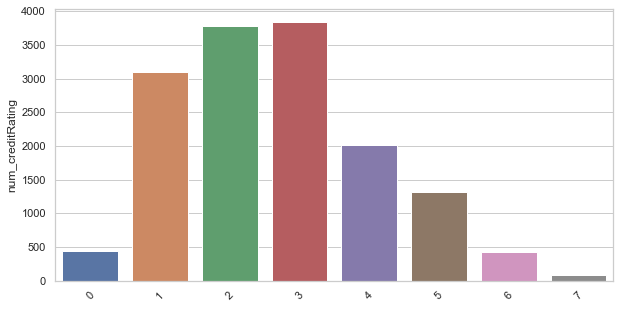

Plot for NTOUCHPOINTS: total counts = 8


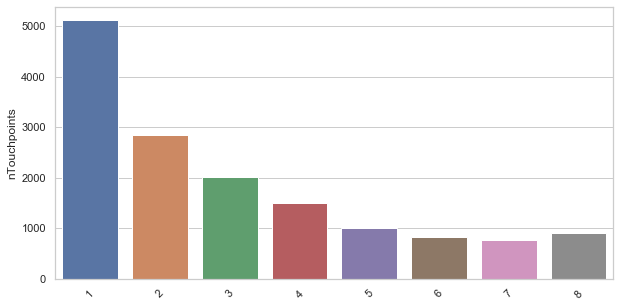

Plot for AGE: total counts = 41


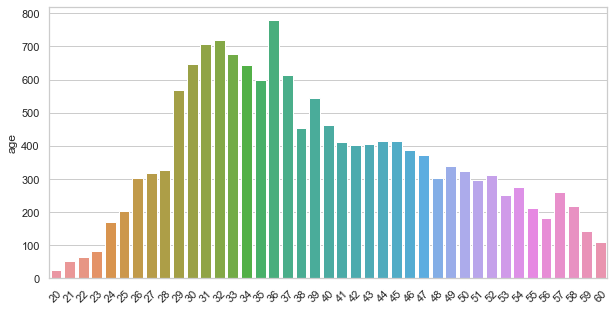

In [20]:
df_explore = data[['marital','segment','SocialMedia','num_creditRating','nTouchpoints','age']]
for cat in df_explore:
    cat_num = df_explore[cat].value_counts()
    print("Plot for %s: total counts = %d" % (cat.upper(), len(cat_num)))
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=cat_num.index, y=cat_num)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    plt.show()

Plot for AGE: total counts = 15000


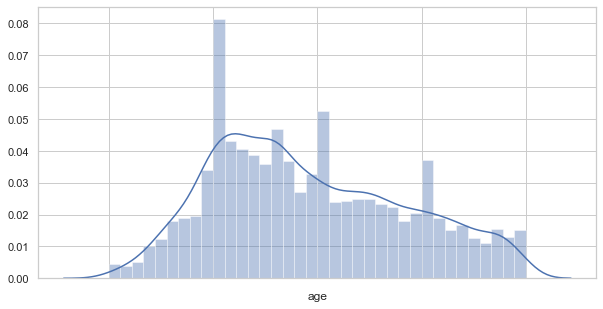

Plot for INCOME: total counts = 15000


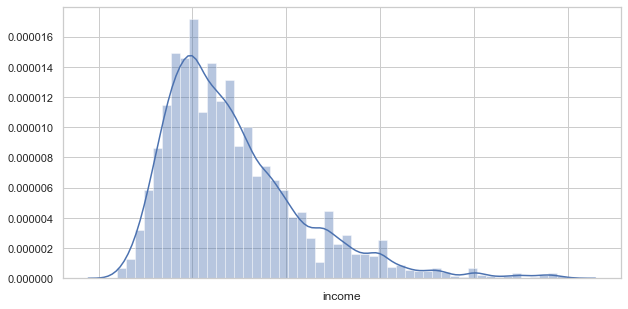

Plot for AVESPEND: total counts = 15000


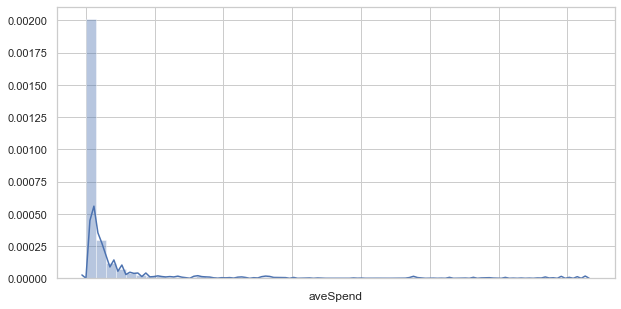

In [21]:
df_explore = data[['age','income','aveSpend']]
for cat in df_explore:
    cat_num = df_explore[cat]
    print("Plot for %s: total counts = %d" % (cat.upper(), len(cat_num)))
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.distplot(cat_num)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    plt.show()

Observations:
1. Age distribution looks normally distributed with slight left skew
2. Number of married > single > divorced > unknown customers.
3. Approximately same number of customers in each category for segment and SocialMedia.
4. Distribution of customers across credit ratings looks normal with slight right skew.
5. Most customers go through only 1 touchpoint
6. Distribution of income looks normal.
7. Average spending distribution can be considered exponential but there are obviously outliers that we have to deal with.

In [22]:
data[data['aveSpend']==max(data['aveSpend'])]

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints,recent_touchpoint,num_creditRating
884,45,married,P1,U,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
2133,30,single,P1,Y,100000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
3198,45,married,P3,U,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
6876,30,single,P1,Y,100000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
7944,30,single,P3,U,100000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
8511,45,married,P4,Y,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
9204,45,married,P4,Y,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
10191,45,married,P1,N,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
10742,45,married,P2,N,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3
12460,45,married,P4,U,50000.0,C,18156.7,smsDiscount smsDestination mailDiscount smsDes...,8,emailDiscount,3


In [23]:
data['aveSpend'].describe()

count    15000.000000
mean       727.190605
std       2214.887088
min          0.000000
25%         20.420000
50%         91.520000
75%        426.892500
max      18156.700000
Name: aveSpend, dtype: float64

I remove all customers earning $18156.7 because our median aveSpend is only at 95.2 which is far from the max value. Leaving them in the data will only skew our aveSpend distribution. 

In [24]:
data = data[data['aveSpend']!=max(data['aveSpend'])]

In [25]:
data #left with 14989 rows

,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints,recent_touchpoint,num_creditRating
0,38,single,P4,U,51000.0,C,5007.50,emailDestination mailDiscount,2,mailDiscount,3
1,39,divorced,P3,U,100000.0,B,19.74,emailDestination mailGift,2,mailGift,2
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3,emailDiscount,4
3,60,married,P4,U,152000.0,C,39.47,mailDiscount,1,mailDiscount,3
4,47,married,P2,Y,60000.0,A,19.89,mailDestination emailDestination emailDestination,3,emailDestination,1
...,...,...,...,...,...,...,...,...,...,...,...
14995,32,married,P1,U,33000.0,E,4280.63,emailDestination emailDestination emailDestina...,7,mailDiscount,5
14996,53,divorced,P3,N,61000.0,F,1332.29,smsDestination mailDiscount emailDestination e...,6,mailDiscount,6
14997,30,single,P4,N,44000.0,C,4010.00,emailDestination emailDestination mailDiscount...,4,mailDiscount,3
14998,52,married,P4,N,71000.0,C,507.46,emailDestination mailGift emailDiscount smsDes...,8,emailDestination,3


### Use one-hot encoding to convert categorical variables (marital, segment, SocialMedia, creditRating) into numerical variables. 

In [26]:
def init_encoder(df, col_names_list):
    d = {}
    for col_name in col_names_list:
        d[col_name] = df[col_name].unique().tolist()
    return d

def one_hot_encoder(df, var_dict):
    for var,vals in var_dict.items():
        for val in vals:
            df[val] = df[var].apply(lambda x: 1 if val in x else 0)
    return df

In [27]:
d = init_encoder(data,['marital','segment','SocialMedia','creditRating'])
one_hot_encoder(data, d)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,age,marital,segment,SocialMedia,income,creditRating,aveSpend,touchpoints,nTouchpoints,recent_touchpoint,...,N,Y,C,B,D,A,F,E,New,G
0,38,single,P4,U,51000.0,C,5007.50,emailDestination mailDiscount,2,mailDiscount,...,0,0,1,0,0,0,0,0,0,0
1,39,divorced,P3,U,100000.0,B,19.74,emailDestination mailGift,2,mailGift,...,0,0,0,1,0,0,0,0,0,0
2,41,married,P4,N,51000.0,D,320.10,emailDiscount mailGift emailDiscount,3,emailDiscount,...,1,0,0,0,1,0,0,0,0,0
3,60,married,P4,U,152000.0,C,39.47,mailDiscount,1,mailDiscount,...,0,0,1,0,0,0,0,0,0,0
4,47,married,P2,Y,60000.0,A,19.89,mailDestination emailDestination emailDestination,3,emailDestination,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,32,married,P1,U,33000.0,E,4280.63,emailDestination emailDestination emailDestina...,7,mailDiscount,...,0,0,0,0,0,0,0,1,0,0
14996,53,divorced,P3,N,61000.0,F,1332.29,smsDestination mailDiscount emailDestination e...,6,mailDiscount,...,1,0,0,0,0,0,1,0,0,0
14997,30,single,P4,N,44000.0,C,4010.00,emailDestination emailDestination mailDiscount...,4,mailDiscount,...,1,0,1,0,0,0,0,0,0,0
14998,52,married,P4,N,71000.0,C,507.46,emailDestination mailGift emailDiscount smsDes...,8,emailDestination,...,1,0,1,0,0,0,0,0,0,0


Added 19 columns

In [28]:
data.to_csv('./marketdata2.csv')

### See next model-building.ipynb for next part